<a href="https://colab.research.google.com/github/gankidisaicharan/Crop-Recommendation-System/blob/main/PlantDiease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
import pathlib
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import pandas as pd
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

In [ ]:
file_path = '/content/drive/MyDrive/PROJECTS/Crop Recommendation system using ML/Dataset/PlantVillage'
data_dir = pathlib.Path(file_path)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


In [ ]:
num_classes=len(class_names)
num_classes

15

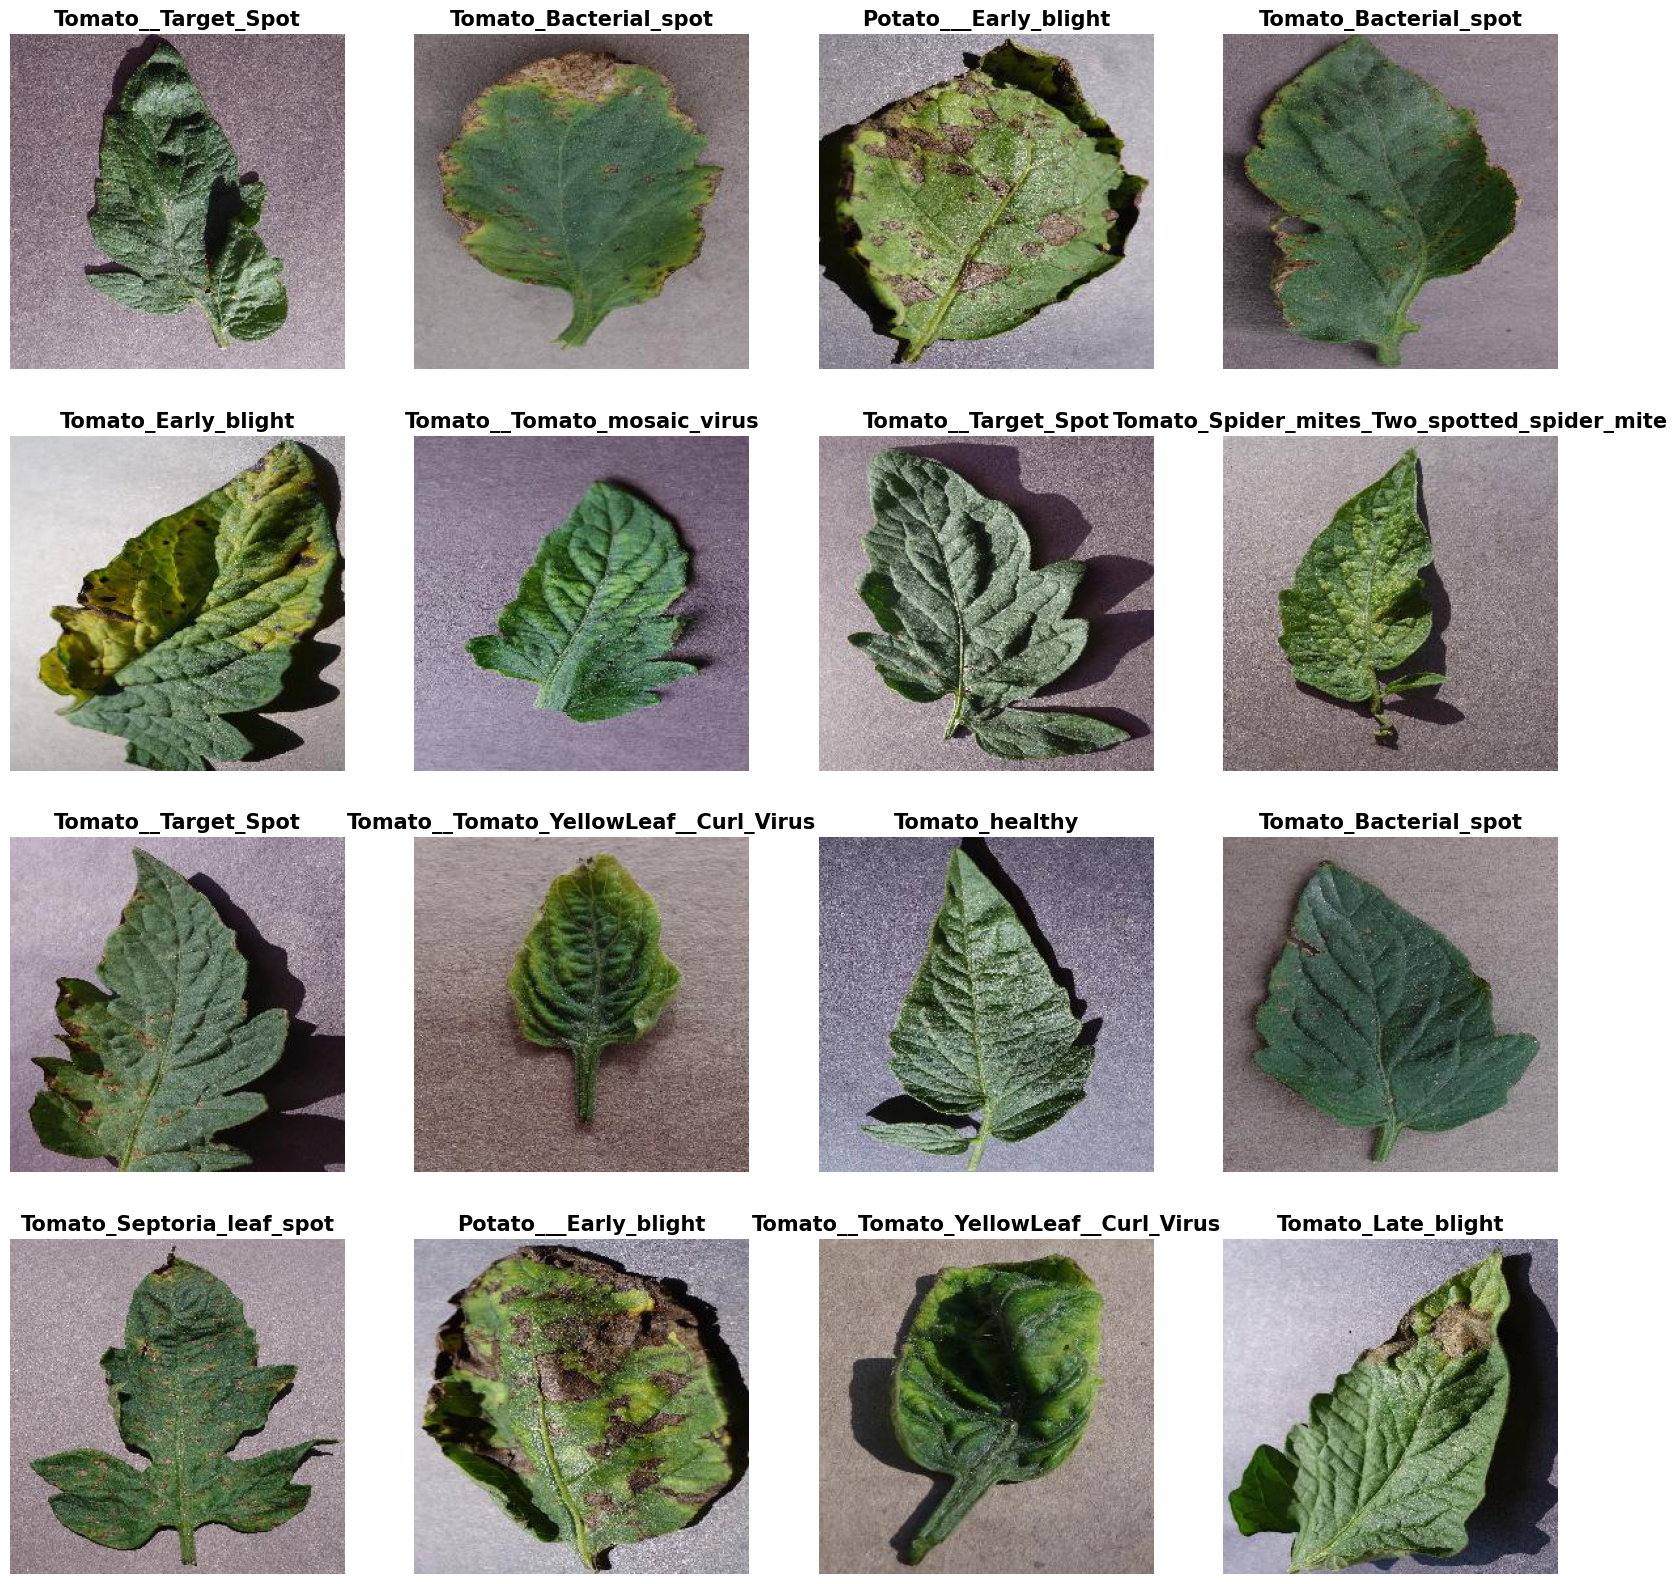

In [ ]:
plt.figure(figsize=(20, 20))
for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    random_class = random.randint(0, 14)
    folder_path = file_path + '/' + class_names[random_class]
    random_image_path = folder_path + '/' + (random.sample(os.listdir(folder_path), 1)[0])
    image = plt.imread(random_image_path)
    plt.axis('off')
    plt.title(class_names[random_class], fontsize = 15, fontweight = 'bold')
    plt.imshow(image)

In [ ]:
import cv2
import imutils
import matplotlib.pyplot as plt

def crop_image_contour(image, plot=False):
    if image is None:
        print("Invalid image")
        return None

    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    if len(cnts) == 0:
        print("No contours found in the image")
        return None

    c = max(cnts, key=cv2.contourArea)
    # extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()

    return new_image


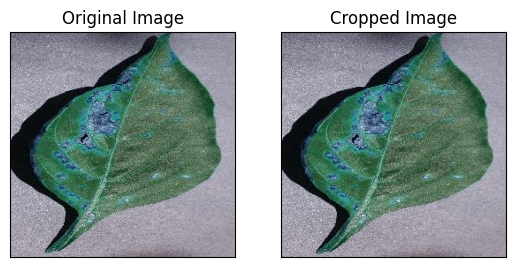

In [ ]:
ex_img = cv2.imread('/content/drive/MyDrive/PROJECTS/Crop Recommendation system using ML/Dataset/PlantVillage/Pepper__bell___Bacterial_spot/0022d6b7-d47c-4ee2-ae9a-392a53f48647___JR_B.Spot 8964.JPG')
ex_crop_img = crop_image_contour(ex_img, True)

<Figure size 2000x2000 with 0 Axes>

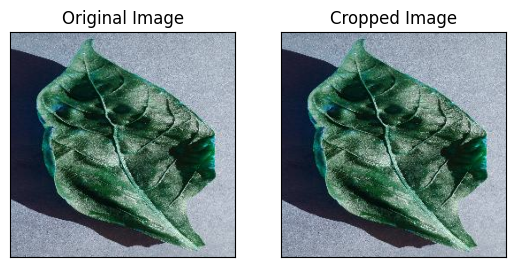

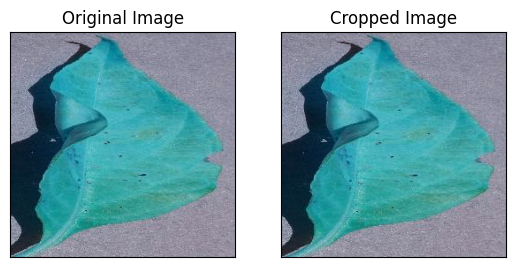

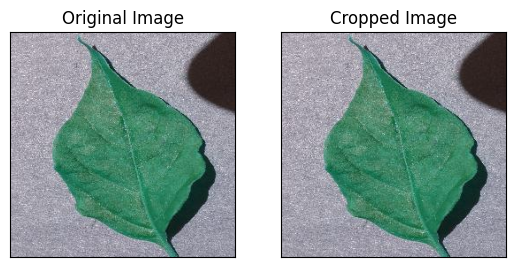

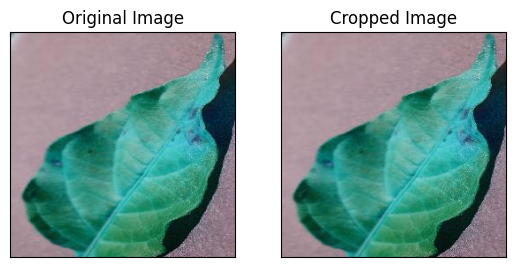

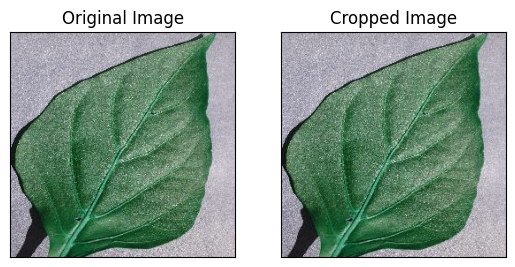

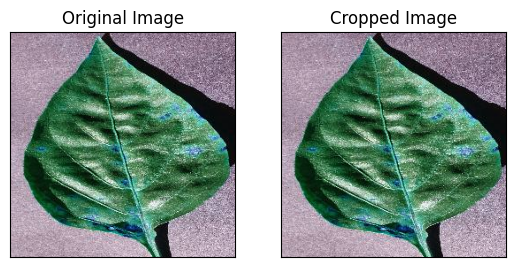

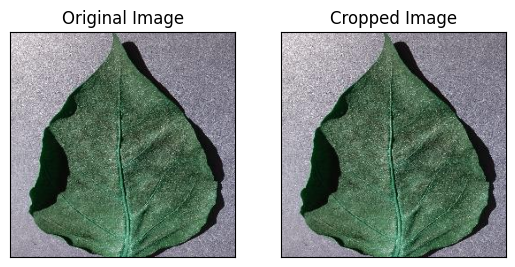

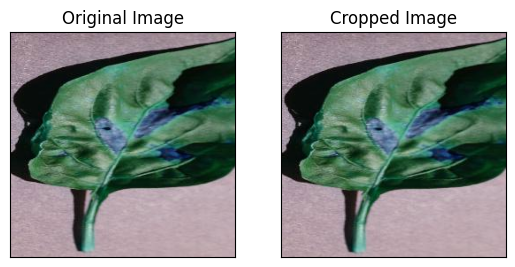

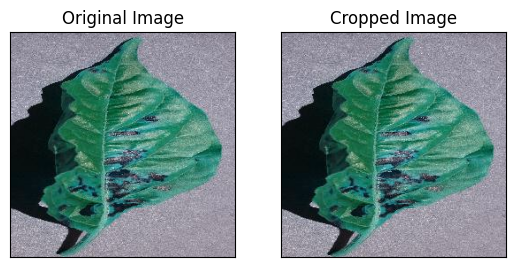

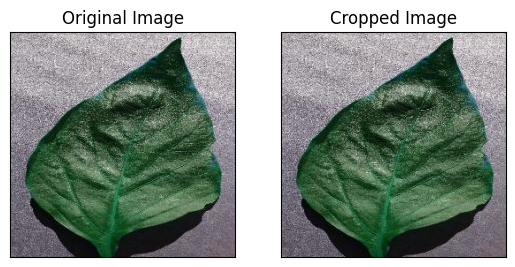

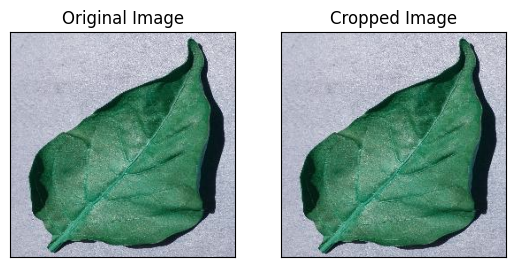

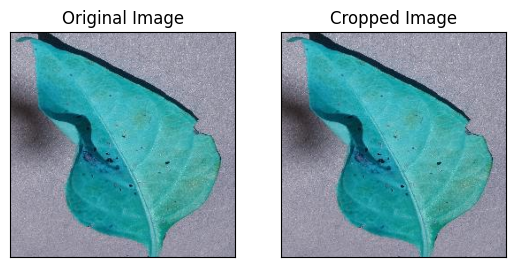

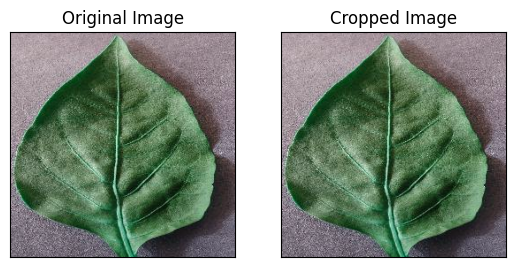

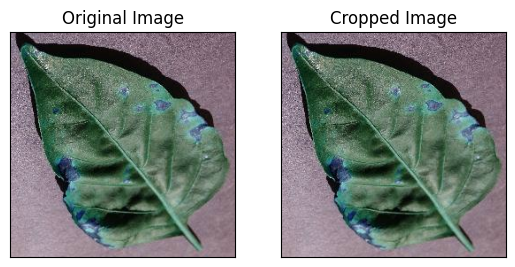

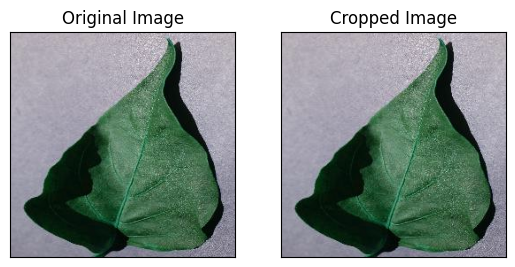

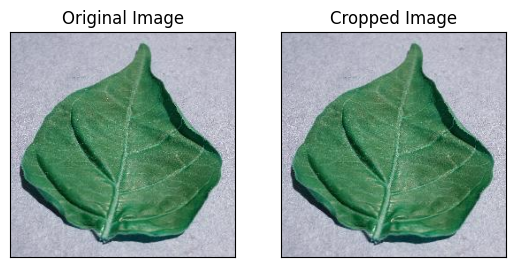

In [ ]:
plt.figure(figsize=(20, 20))
for i in range(16):
    random_class = random.randint(0, 1)
    folder_path = file_path + '/' + class_names[random_class]
    random_image_path = folder_path + '/' + (random.sample(os.listdir(folder_path), 1)[0])
    image = cv2.imread(random_image_path)
    ex_crop_img = crop_image_contour(image, True)

In [ ]:
SEED = 1
BATCH_SIZE = 32
IMG_SIZE = (128, 128)

X_train = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    seed = SEED,
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    validation_split = 0.2,
    subset = 'training'
)

X_validation = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    seed = SEED,
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    validation_split = 0.2,
    subset = 'validation'
)

Found 20638 files belonging to 15 classes.
Using 16511 files for training.
Found 20638 files belonging to 15 classes.
Using 4127 files for validation.


In [ ]:
IMG_SIZE=(128,128)
INPUT_SHAPE = IMG_SIZE + (3,)
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Rescaling(scale=1./255, input_shape=INPUT_SHAPE))
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.20))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(num_classes, activation = 'softmax'))

In [ ]:
# Set the hyperparameters
learning_rate = 0.0001
num_epochs = 30
early_stop_patience = 10

In [ ]:
optimizer = Adam(learning_rate=learning_rate)

In [ ]:
# Set up callbacks for the training process
log_dir = 'logs/'
tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
model_filepath='/content/drive/MyDrive/PROJECTS/Crop Recommendation system using ML/Dataset/models_cnn/model-{epoch:02d}-{val_accuracy:.4f}.hdf5'
checkpoint = ModelCheckpoint(model_filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
early_stop_callback = EarlyStopping(monitor='val_loss', patience=early_stop_patience)

In [ ]:
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        1

In [ ]:
batch_size=512
epochs=50

In [ ]:
history = model.fit(X_train,epochs=num_epochs, validation_data=X_validation,verbose=1,callbacks=[tb_callback,checkpoint, reduce_lr_callback, early_stop_callback])

Epoch 1/30
516/516 [==============================] - ETA: 0s - loss: 1.8462 - accuracy: 0.4072
Epoch 1: val_accuracy improved from -inf to 0.64405, saving model to /content/drive/MyDrive/PROJECTS/Crop Recommendation system using ML/Dataset/models_cnn/model-01-0.6441.hdf5
516/516 [==============================] - 50s 82ms/step - loss: 1.8462 - accuracy: 0.4072 - val_loss: 1.1103 - val_accuracy: 0.6441 - lr: 1.0000e-04
Epoch 2/30
516/516 [==============================] - ETA: 0s - loss: 0.9451 - accuracy: 0.6928
Epoch 2: val_accuracy improved from 0.64405 to 0.74219, saving model to /content/drive/MyDrive/PROJECTS/Crop Recommendation system using ML/Dataset/models_cnn/model-02-0.7422.hdf5
516/516 [==============================] - 44s 84ms/step - loss: 0.9451 - accuracy: 0.6928 - val_loss: 0.7465 - val_accuracy: 0.7422 - lr: 1.0000e-04
Epoch 3/30
514/516 [============================>.] - ETA: 0s - loss: 0.6748 - accuracy: 0.7737
Epoch 3: val_accuracy improved from 0.74219 to 0.80155,

[]

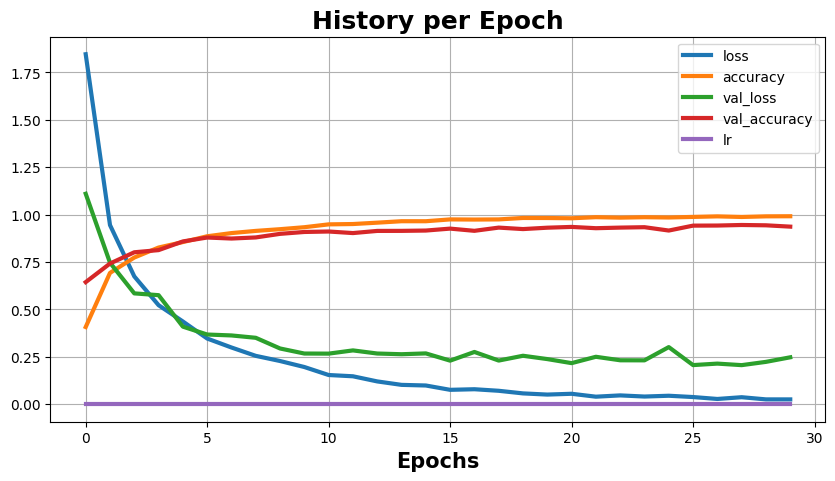

In [ ]:
df = pd.DataFrame(history.history)
ax = df.plot(figsize=(10,5), lw=3, grid='on')
ax.set_title('History per Epoch', fontsize=18, fontweight='bold')
ax.set_xlabel('Epochs', fontsize=15, fontweight='bold')
ax.plot()

In [ ]:
# Load the saved model
from tensorflow.keras.models import Model,load_model
model = load_model('/content/drive/MyDrive/PROJECTS/Crop Recommendation system using ML/Dataset/models_cnn/model-28-0.9455.hdf5')

In [ ]:
model_evaluate = model.evaluate(X_validation)
print("Accuracy: %", "{:.2f}".format(model_evaluate[1]*100))
print("Loss: %", "{:.2f}".format(model_evaluate[0]*100))

In [ ]:
plt.figure(figsize=(20, 20))
for image, label in X_validation.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i+1)
        img = image[i].numpy().astype("uint8")
        img = tf.expand_dims(img, axis=0)
        predicted_class = np.argmax(model.predict(img))
        plt.axis('off')
        plt.title("True Label: " + class_names[label[i]]+'\n', fontsize=8, style='italic', color='blue', loc='center')
        plt.title("Predict Label: " + class_names[predicted_class], fontsize=8, fontweight='bold', color='green', loc='right')
        plt.imshow(image[i].numpy().astype("uint8"))

In [ ]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 77.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.5/140.5 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 68.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 

In [ ]:
import gradio as gr
import cv2
from tensorflow.keras.models import Model,load_model
model = load_model('/content/drive/MyDrive/PROJECTS/Crop Recommendation system using ML/Dataset/models_cnn/model-28-0.9455.hdf5')
# Define a function to run the model on user input and return predictions
def predict_image(img_array):
    img_array = cv2.resize(img_array, (128, 128))
    img_array = np.array(img_array).reshape(1, 128, 128, 3)
    prediction = model.predict([img_array])
    class_idx = np.argmax(prediction)
    class_name = class_names[class_idx]
    return class_name

# Define the input and output components of the Gradio interface
inputs = gr.inputs.Image(shape=(128, 128))
outputs = gr.outputs.Label(num_top_classes=len(class_names))

# Create the Gradio interface
interface = gr.Interface(fn=predict_image, inputs=inputs, outputs=outputs,
                         title='Leaf Disease Prediction',
                         description='Upload an image and the model will predict whether it shows signs of Leaf was diseased or not.')

# Launch the interface
interface.launch(share=True,debug=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://e288dcc59b70c36cce.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://e288dcc59b70c36cce.gradio.live
